In [1]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import signal

%matplotlib inline

# P411 - Assignment 8
Kristi Webb, Nov 7 2015

github k-a-webb

## **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

In [2]:
N = 1000
dt = 0.1  # seconds
t = np.arange(0, N*dt, dt)
fnyq = 0.5/dt
B = 0.5  # Hz, band limit (bandwidth?)

x = np.random.randn(N)  # white noise

# filter to make Bandlimited signal
fp = B*0.7 # passband
fs = B*0.9  # stop band
n, fn = signal.ellipord(fp/fnyq, fs/fnyq, .1, 60.)
b, a = signal.ellip(n, .1, 60., fn)
x_bl = signal.filtfilt(b, a, x)  # bandlimited signal

Nfft = 256
args = {'NFFT':Nfft,'Fs':1./dt,'noverlap':Nfft/2.,'window':mlab.window_hanning}

pxx, f = mlab.psd(x, **args)
px_bl, f = mlab.psd(x_bl, **args)

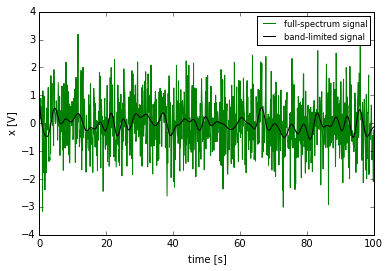

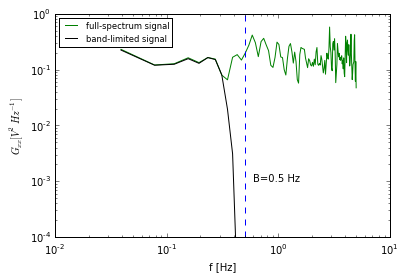

In [3]:
plt.plot(t, x, '-g', label='full-spectrum signal')
plt.plot(t, x_bl, '-k', label='band-limited signal')
plt.xlabel('time [s]') ; plt.ylabel('x [V]') ; plt.legend(fontsize='small',loc=0) ; plt.show()

plt.loglog(f, pxx, '-g', label='full-spectrum signal')
plt.loglog(f, px_bl, '-k', label='band-limited signal')
plt.axvline(x=B, linestyle='--') ; plt.text(B+0.1, 1e-3, 'B={} Hz'.format(B))
plt.ylim(10e-5, 1)
plt.xlabel('f [Hz]') ; plt.ylabel('$G_{xx} [V^2 Hz^{-1}]$') ; plt.legend(fontsize='small',loc=0) ; plt.show()

<div style='background:#F0F0F0'>**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz.  Show that you can recover the 10 Hz time series using the Sampling Theorem.</div>

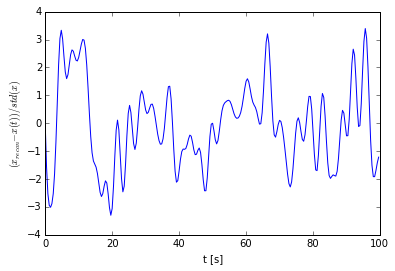

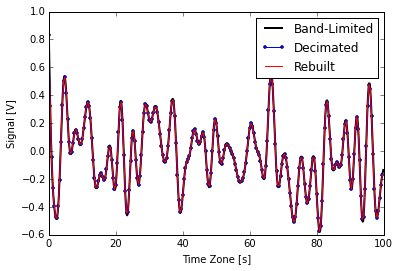

In [18]:
sampling = 2.5           
fr = 4

tn = t[::fr]
xn = x_bl[::fr]
xreco = 1. * x_bl[:N/fr]  # trim the last N*4 data points...
n = np.arange(N/fr)

# 2*B = 1/dt = 2*f_nyq where f_nyq = Sample Frequency/2

for i in n:
    xreco[i] = np.sum(xn[:N] * np.sinc(sampling*tn[i] - n))
    
plt.plot(tn, (xreco - x_bl[:N/fr])/np.std(x_bl))
plt.xlabel('t [s]') ; plt.ylabel('$(x_{recon}-x(t))/std(x)$') ; plt.show()
    
plt.plot(t, x_bl, '-k', label='Band-Limited', linewidth=2)
plt.plot(tn, xn, label='Decimated', marker='o', markersize=3)
plt.plot(tn, xreco, '-r', label='Reconstructed')
plt.xlabel('t [s]') ; plt.ylabel('x [V]') ; plt.legend() ; plt.show()

We see that the bandlimited spectrum is recovered pretty well for sampling of 1/4th of the data (i.e. sampled at 2.5 Hz rather than the full 10Hz)

<div style='background:#F0F0F0'>**3** Now decimate by a factor of 40 to get a time series sampled at 0.25 Hz.  Show that you cannot recover the 10 Hz time series using the Sampling Theorem.</div>

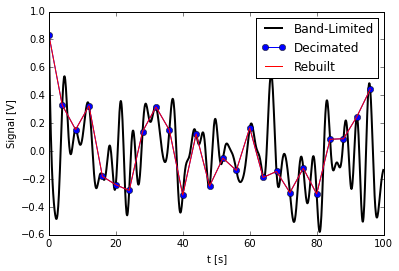

In [20]:
sampling = 0.25           
fr = 40

tn = t[::fr]
xn = x_bl[::fr]
xreco = 1. * x_bl[:N/fr]  # trim the last N*4 data points...
n = np.arange(N/fr)

for i in n:
    xreco[i] = np.sum(xn[:N] * np.sinc(sampling*tn[i] - n))

plt.plot(t, x_bl, '-k', label='Band-Limited', linewidth=2)
plt.plot(tn, xn, label='Decimated', marker='o', markersize=6)
plt.plot(tn, xreco, '-r', label='Reconstructed')
plt.xlabel('t [s]') ; plt.ylabel('x [V]') ; plt.legend() ; plt.show()

The sample is not well recovered at all when the sampling is 1/40th of the original signal.

## Q2: Cubic Spline

**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

In [59]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x = np.cos(t*2*np.pi/3)

So suppose, we have $N+1$ data points, $n=0,1,..N$, then we have $N$ segments between the data points, $i=0,1,...,N-1$.  We want the fit $q(t)$ to go through the data and for the derivatives to be continuous at the data points.  Let $q_i(t)$ be the fit between $t_i$ and $t_{i+1}$:

$$q_i(t)=a_i + b_i(t-t_i)+c_i(t-t_i)^2+d_i(t-t_i)^3.$$ 

...


\begin{align}
    x_i +\Delta_ib_i +\Delta_i^2c_i + \Delta_i^3d_i&=x_{i+1} \ \ \ \ \ \ \text{for}\ i=0...N-1\\
    b_i+2\Delta_ic_i+3\Delta_i^2d_i &=b_{i+1}\ \ \ \ \text{for}\ i=0...N-2\\
    2c_i+6d_i\Delta_i&=2c_{i+1}\ \ \ \ \text{for}\ i=0...N-2\\
    c_0&=0\\
    2c_{N-1}+6d_{N-1}\Delta_{N-1}&=0
\end{align}

...

\begin{equation}
\begin{pmatrix}
    1 & 0 & 0 & \cdots & \cdots & \cdots & \cdots\\
    \Delta_0 & 2\left(\Delta_0+\Delta_1\right) & \Delta_1 & \cdots & \cdots & \cdots & \cdots\\
    \cdots & \cdots & \ddots & \cdots & \cdots & \cdots & \cdots\\
    \cdots & \cdots & \cdots  & \Delta_{N-3} & 2\left(\Delta_{N-3}+\Delta_{N-2} \right) & \Delta_{N-2} & 0\\
    \cdots & \cdots & \cdots &\cdots & \Delta_{N-2} & 2\left(\Delta_{N-2}+\Delta_{N-1} \right) & \Delta_{N-1}\\
    \cdots & \cdots & \cdots & \cdots & \cdots & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    c_0\\
    c_1\\
    c_2\\
    \vdots\\
    c_{N-2}\\
    c_{N-1}\\
    c_{N}
\end{pmatrix}
= 3\begin{pmatrix}
    0\\
    \frac{dx_1}{\Delta_1}-    \frac{dx_0}{\Delta_0}\\
    \frac{dx_2}{\Delta_2}-    \frac{dx_1}{\Delta_1}\\
    \vdots\\
    \frac{dx_{N-1}}{\Delta_{N-1}}-    \frac{dx_{N-2}}{\Delta_{N-2}}\\   
    0
\end{pmatrix}
\end{equation}

In [82]:
f = interpolate.interp1d(t, x, kind='cubic')
tyn = np.arange(0, 9, 0.09)
y = f(tyn)

In [113]:
Np1 = len(t)  # Number of data points
N = Np1 - 1  # segments between data points

tt = np.diff(t)
xx = np.diff(x)

# Create matrix
M = np.zeros((Np1,Np1))
M[0,0] = 1
M[N, N] = 1
for i in range(N-1):  # fill rest of diagnal and near diagnals with proper values
    M[i+1, i] = tt[i]
    M[i+1, i+1] = 2*(tt[i] + tt[i+1])
    M[i+1, i+2] = tt[i+1]
print 'Matrix:\n{}'.format(M)
    
# create vector on RHS of above equation
A = np.zeros(Np1)
for i in range(1, N):
    A[i] = 3 * (xx[i]/tt[i] - xx[i-1]/tt[i-1])
A[-1] = 0.
    
c = np.linalg.solve(M, A)  # solve for coefficients

Matrix:
[[ 1.   0.   0.   0.   0.   0.   0. ]
 [ 2.5  5.4  0.2  0.   0.   0.   0. ]
 [ 0.   0.2  1.8  0.7  0.   0.   0. ]
 [ 0.   0.   0.7  3.   0.8  0.   0. ]
 [ 0.   0.   0.   0.8  6.2  2.3  0. ]
 [ 0.   0.   0.   0.   2.3  9.6  2.5]
 [ 0.   0.   0.   0.   0.   0.   1. ]]


In [122]:
# solve for other coefficients

a = 1.*x  # a values are just the x values

d = np.zeros(N)
for i in range(N-2):
    d[i] = 2*(c[i+1] - c[i])/(6*tt[i])
d[N-1] = -2*c[N-1]/(6*tt[N-1])

b = np.zeros(N)
for i in range(N-1):
    b[i] = ((x[i+1] - x[i]) - (tt[i]**3 * d[i]) - (tt[i]**2 * c[i])) / tt[i]


$$q_i(t)=a_i + b_i(t-t_i)+c_i(t-t_i)^2+d_i(t-t_i)^3.$$ 


In [154]:
q = np.zeros((N,15))
t2 = np.zeros((N,15))

for i in range(N):
    ti = np.linspace(t[i], t[i+1], 15)
    for j in range(0,15):
        q[i,j] = a[i] + b[i]*(ti[j]-t[i]) + c[i]*(ti[j]-t[i])**2 + d[i]*(ti[j]-t[i])**3
    
    ##Create a full time series from the time series spaces
    t2[i,] = ti

##Make 1-D arrays for plotting
t2 = t2.flatten()
q = q.flatten()
tq = t2

In [160]:
NN = 15 #len(tyn)/N  # to make it approximately the same size as tyn
qq = np.zeros((N,NN))
tqq = np.zeros((N,NN))

# Need to iterate through values of a,b,c,d and also time to solve for q(t)
#   make a 2D matrix, then flatten
for i in range(N):
    ti = np.linspace(t[i], t[i+1], NN)
    tqq[i,] = ti
    for j in range(NN):
        qq[i,j] = a[i] + b[i]*(ti[j]-t[i]) + c[i]*(ti[j]-t[i])**2 + d[i]*(ti[j]-t[i])**3

q = qq.flatten()
tq = tqq.flatten()

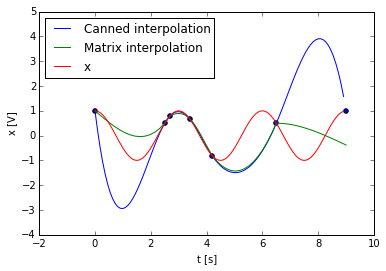

In [163]:
plt.plot(tyn, y, label='Canned interpolation')
plt.plot(tq, q, label='Matrix interpolation')
plt.scatter(t, x, marker='o')
plt.plot(tyn, np.cos(tyn*2*np.pi/3), label='x')
plt.legend(loc=2) ; plt.xlabel('t [s]') ; plt.ylabel('x [V]') ; plt.show()

### Comment